<a href="https://colab.research.google.com/github/dnevo/ImageProcessing/blob/main/ImageProcessingRecitation_07_BinaryImages_ConnectedComponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve
import random
random.seed(3)

In [ ]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

def read_file(fname:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image 
    in a numpy array.

    Args:
        fname: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, fname)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [ ]:
def histogram(img:np.array) -> np.array:
    hist = np.zeros(256, dtype='int16')
    nrows, ncols = img.shape
    for r in range(nrows):
        for c in range(ncols):
            hist[img[r, c]] += 1
    return hist

In [ ]:
def plot_img_hist(img:np.array):
    hist = histogram(img)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    axes[0].imshow(img,  cmap='gray', vmin=0, vmax=255)

    axes[1].set_xlim([0, 256])
    axes[1].set_ylim([0, hist[1:-1].max()])
    axes[1].bar(np.arange(len(hist)),height=hist);

In [ ]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

# 7. Binary Images and Connected Components

##7.1 Binary Images

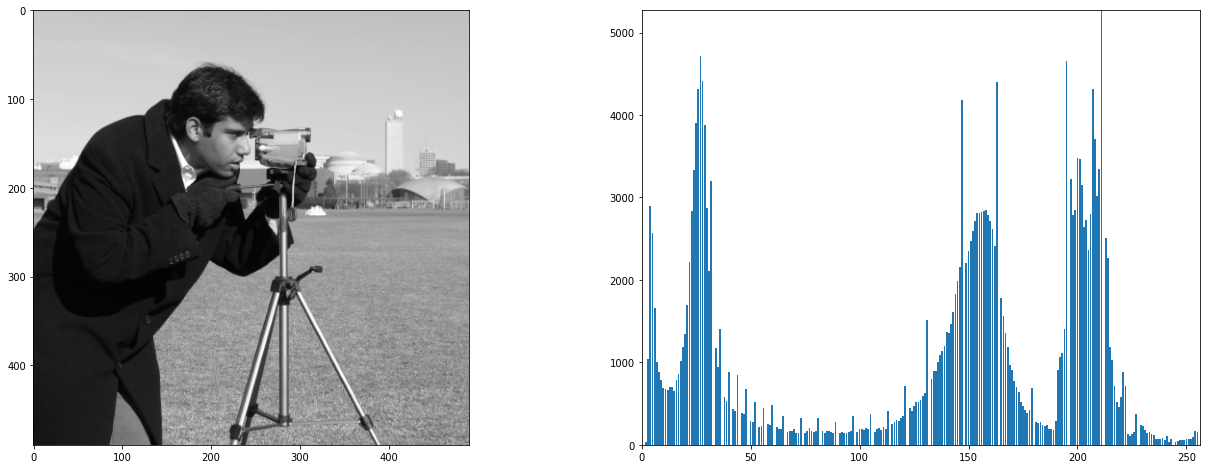

In [ ]:
img = read_file('camera1.tif')[:,:,0]
plot_img_hist(img)

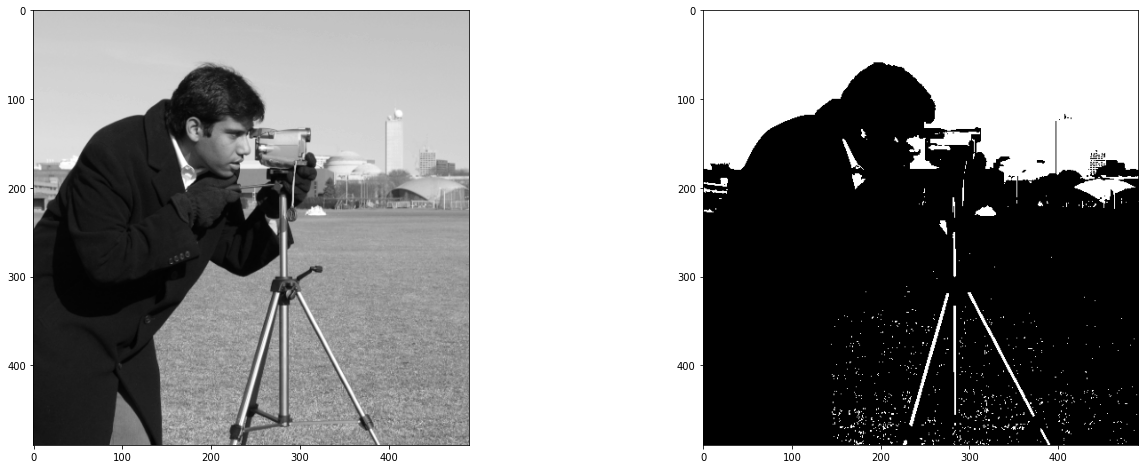

In [ ]:
img_b = (img > 180).astype('int16')
plot_images(img, img_b)

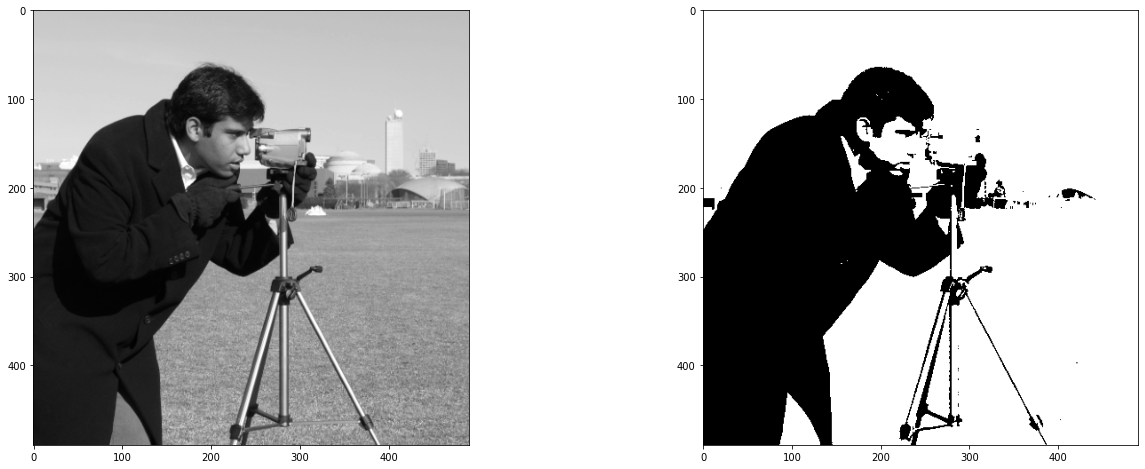

In [ ]:
img_b = (img > 90).astype('int16')
plot_images(img, img_b)

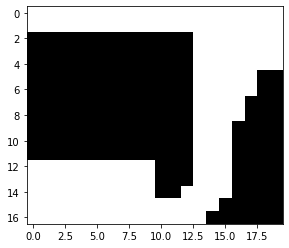

In [ ]:
plt.imshow(img_b[210:227,:20], cmap='gray');

In [ ]:
print(img_b[210:227,:20])

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]]


##7.2 Connected Components

Connected-component labeling is used in computer vision to detect connected regions in binary digital images. 

Usage: geometric feature extraction, segmentation, blob detection

**A pixel can have 4 or 8 neighbours:**

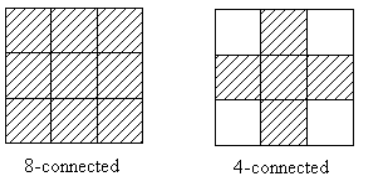

**Tag Connected Components algorithm**

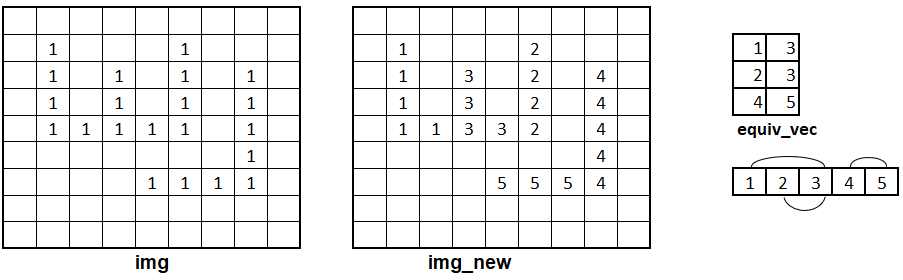

1. Scan left to right and top to bottom.
2. If pixel = 1:
    1. If just above pixel or just left pixel has a tag, copy it.
    2. If both neighbors have the same tag, copy it.
    3. If neighbors have different tags, copy the top tag, and put the tag in the equivalence table.
    4. Otherwise (no above and left neighbors), add a new tag.

In [ ]:
I = np.array([[1,0,1,0,0],
              [0,1,1,0,0],
              [1,1,1,0,0],
              [0,0,0,1,1],
              [0,0,0,1,1]])
I2 = I@I
I2

array([[2, 1, 2, 0, 0],
       [1, 2, 2, 0, 0],
       [2, 2, 3, 0, 0],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2]])

**Create the cliques** 

Note that: $I^2_{i,j}=\sum_{{k=1}}^{{n}}{I_{i,k} \times I_{k,j}}$

Therefore if $i$ is connected to $k$, and $k$ connected to $j$, $i$ will get connected to $j$. In other words: if edge $i$ is connected to edge $j$ via intermediate edge $k$.

It will be enough to perform $log(n)$ multiplications.

A pseudo code:
```python
I2 = I
while True:
    I = I2
    I2 = I @ I
    I2 = min(I2, 1)
    if I2 == I:
        break
```


In [ ]:
I2 = np.minimum(I2, 1)
I2

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1]])

**Build the conversion vector**
- We will scan `I2` line by line
- Find the index of first zero.
- Multiply the next lines by next consecutive tag.

- `i=0, cv = I2[0], tagmin=1, cv_len=5`
- `loop i in (1,5):`
  - `if cv[i]==0:`
    - `tagmin=tagmin+1`
    - `cv = cv + I2[i]*tagmin`

we will get: `[1,1,1,2,2]`

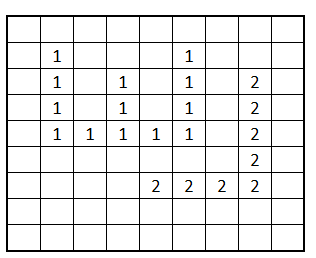

To summarize, there are 4 consecutive loops in the algorithm:
1. scan the binary image and create the **equivalence table**.
   1. input: img - binary image, shape: (nrows, ncols)
   2. create img_new - filled with zeros, shape (norws, ncols)
   3. while scanning:
      - fill img_new with tags
      - increment tag when needed (maxtag)
      - add tuple (i, j) to to equiv_vec. meaning - itag i connected to tag j
   4. create equiv_table, shape (maxtag, maxtag) using equiv_vec. diagonal should have 1s.
2. convert equivalence table to a **clique matrix**, and locate the cliques using matrix multiplications.
   1. create equiv2 - the full connection matrix - equiv2(i, j) == 1 if equiv(i, k) == 1 and equiv(k, j) == 1. the procedure is repeated till all indirect connections are included
3. build the **conversion vector**.
4. create a **connected components image** using the conversion vector.

